In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
import uproot4
import pandas as pd

import Utilities.Plotter as PT
import Utilities.Constants as Constants
import Utilities.Variables_list as Variables
import Utilities.Functions as Functions


ModuleNotFoundError: No module named 'Utilities'

In [10]:
file_cv = uproot4.open("E:/run1_NuMI_CV_sp.root")
tree_cv = file_cv["singlephotonana;1/vertex_tree;1"]
pot_cv= file_cv["singlephotonana;1/pot_tree;1"]

cv = tree_cv['ppfx_cv'].array(library="ak")
PPFX = tree_cv['weightsPPFX'].array(library="ak")
shwr_max_energy = tree_cv['reco_shower_energy_max'].array(library='ak')
shower_number = tree_cv['reco_asso_showers'].array(library="ak")
track_number = tree_cv['reco_asso_tracks'].array(library='ak')
pot_number = pot_cv['POT'].array(library='ak')
pot_exp_R1 = 2e+20

shower_energy = []
shower_energy_cut1 = []
shower_energy_cut2 = []

index=0
for i,j in zip(shower_number,track_number):
    if(i == 1 and j == 0):
        energy = cv[index][0]
        shower_energy_cut1.append(energy)
    index+=1


for k in cv:
    for energy in k:
        shower_energy.append(energy)

energy = np.array(shower_energy)/1000
energy_cut1 = np.array(shower_energy_cut1)/1000
energy_cut2= np.array(shower_energy_cut2)/1000

POT= np.sum(pot_number)
weigh = pot_exp_R1 / np.sum(pot_number)
print('POT of =', POT)


IndexError: invalid index to scalar variable.

ValueError: weights should have the same shape as x

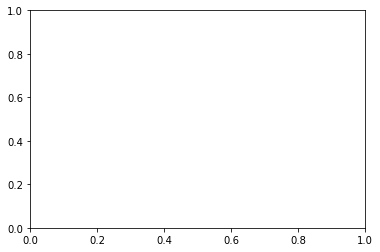

In [9]:
bins=np.linspace(0,1.0,21)
bins_cent=(bins[:-1]+bins[1:])/2
plt.hist(bins_cent,bins,weights=cv,color="red",histtype="step",label="Central Value",lw=2,linestyle='-')
plt.legend()
plt.show()

In [ ]:
def All_reweight_err(df, var_name, n_bins, x_range, Norm):
    results_dict = {}
    for Multisim in Constants.Multisim_univs:
        Nuniverse = Constants.Multisim_univs[Multisim]
        n_tot = np.empty([Nuniverse, n_bins])
        n_cv_tot = np.empty(n_bins)
        n_tot.fill(0) 
        n_cv_tot.fill(0)
        
        variable = df[var_name] #The BDT output score
        syst_weights = df[Multisim] #An array of length of the number of events, each entry is an array of length Nunivs
        spline_fix_cv  = df["weight"]*Norm
        spline_fix_var = df["weight"]*Norm
        
        s = syst_weights
        df_weights = pd.DataFrame(s.values.tolist())
        n_cv, bins = np.histogram(variable, range=x_range, bins=n_bins, weights=spline_fix_cv)
        n_cv_tot += n_cv
        

                    
        if(Multisim == "weightsPPFX"): #special treatment as ["PPFXPcv"] is included in ppfx weights
            if not df_weights.empty:
                for i in range(Nuniverse):
                    weight = df_weights[i].values / 1000.
                    weight[weight == 1]= df["ppfx_cv"].iloc[weight == 1]
                    weight[np.isnan(weight)] = df["ppfx_cv"].iloc[np.isnan(weight)]
                    weight[weight > 100] = df["ppfx_cv"].iloc[weight > 100]
                    weight[weight < 0] = df["ppfx_cv"].iloc[weight < 0]
                    weight[weight == np.inf] = df["ppfx_cv"].iloc[weight == np.inf]
                
                    n, bins = np.histogram(variable, weights=weight*np.nan_to_num(spline_fix_var/df["ppfx_cv"]), range=x_range, bins=n_bins)
                    n_tot[i] += n

        cov = np.empty([len(n_cv), len(n_cv)])
        cov.fill(0)

        for n in n_tot:
            for i in range(len(n_cv)):
                for j in range(len(n_cv)):
                    cov[i][j] += (n[i] - n_cv_tot[i]) * (n[j] - n_cv_tot[j])

        cov /= Nuniverse
        results_dict[Multisim] = [cov,n_cv_tot,n_tot,bins]
    return results_dict

In [ ]:
def Plot_multisim(results_dict, HNL_mass, savefig=False):
    for Multisim in results_dict:
        Nuniverse = Constants.Multisim_univs[Multisim]
        cov = results_dict[Multisim][0]
        cv = results_dict[Multisim][1]
        n_tot = results_dict[Multisim][2]
        bins = results_dict[Multisim][3]
        
        fig,ax = plt.subplots(nrows=2, ncols=1, sharex=True, gridspec_kw={'height_ratios': [3, 1]}, figsize=[10,10],dpi=200)
        plt.sca(ax[0])

        bins=np.linspace(0,1.0,21)

        bins_cent=(bins[:-1]+bins[1:])/2
        bins_centlong=np.tile(bins_cent,Nuniverse)

        nybins=70

        plt.title(Multisim + " Variations",fontsize=20)

        plt.hist(bins_cent,bins,weights=cv,color="red",histtype="step",label="Central Value",lw=2,linestyle='-')
        plt.legend()
        bins_cent=(bins[:-1]+bins[1:])/2
        bins_centlong=np.tile(bins_cent,Nuniverse)

        plt.ylabel("Events")
        plt.hist2d(bins_centlong,n_tot.flatten(),bins=[bins,nybins],cmin=1,range=[[0,1.0],[0,max(cv)*1.4]],rasterized=True)

        plt.colorbar(pad=0,use_gridspec=True)
        #fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap),pad=0,use_gridspec=True)
        plt.ylim(0,max(cv)*1.4)
        # plt.yscale("log")

        plt.sca(ax[1])
        
        #ax[1].tick_params(labelright=False, length=0)
        pos = ax[0].get_position()
        pos2 = ax[1].get_position()
        ax[1].set_position([pos.x0,pos2.y0,pos.width,pos2.height])
        
        plt.hist(bins_cent,bins,weights=np.sqrt(np.diag(cov))/cv*100,color="black",histtype="step",lw=3,linestyle='-')
        plt.ylim(0,30)
        plt.ylabel("% Uncertainity")
        #plt.yticks([])
        plt.xlabel(f"BDT score ({HNL_mass} MeV HNL) ",fontsize=25)
        if savefig == True:
            plt.savefig("plots/Sys_uncertainty/Overlay/" + Run + "_" + str(HNL_mass) + "_MeV_" + Multisim + ".png")